# Parte B. 
### Elaboração de um conjunto de scripts e funções em Python, NumPy, SciPy e Scikit-learn para realizar as tarefas de Aprendizagem Computacional e Avaliação

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# importar livraria que contem as funcoes das features
import featuresFunctions
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

# ex 4
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

C:\Users\fredc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\fredc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\fredc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


___

# 0. Utility functions

In [2]:
def get_classes(target):
    return np.unique(target)

### 0.1. Loading human activities dataset

In [3]:
def load_human_activities_dataset():
    loc = []

    for i in range (0,15):
        loc.append("FORTH_TRACE_DATASET-master/part" + str(i) + "/part" + str(i) + "dev2.csv")

    array = []
    for file in loc:
        df = pd.read_csv(file, sep=',', header=None)
        array.append(df.to_numpy())

    array = np.concatenate(array)
    #print(array.shape)

    return array

# hacti - HumanACTIvities
hacti_data = load_human_activities_dataset()
hacti_input = hacti_data[:, :11]
hacti_target = hacti_data[:, -1]

hacti_classes = get_classes(hacti_target)

dummy = hacti_data[:6]
dummy_input = dummy[:, :11]
dummy_target = dummy[:, -1]

hacti_classes

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16.])

### 0.2. Loading Iris dataset

150 instances <br>
4 atributes:
1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm

3 classes:
- Iris Setosa
- Iris Versicolour
- Iris Virginica

In [4]:
from sklearn.datasets import load_iris

iris_data = load_iris()

df = pd.DataFrame(iris_data.data, columns = iris_data.feature_names)
df['target'] = iris_data.target
print(df)
iris_df = df
iris_input = iris_data.data
iris_target = iris_data.target

iris_classes = get_classes(iris_target)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     target  
0         0  

___

# 1. Data splitting e métricas de exactidão em machine learning
### 1.1. Usando o scikit-learn, desenvolva um conjunto de funções para **data splitting** usando dois cenários:

### 1.1.1. Train-Test (TT) e Train-Validation-Test data split

Divides x (input) and y (target) in: <br>
- x_train = x * test_perc   
- x_val = x * val_perc         
- x_test = x - x_train - x_val
- y_train = y * test_perc     
- y_val = y * val_perc
- y_test = y - y_train - y_val

In [5]:
def tt(x, y, test_perc):
    test_size = test_perc * 0.01
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=1)

    return x_train, x_test, y_train, y_test


def tvt(x, y, val_perc, test_perc):
    test_size = test_perc * 0.01
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=1)

    # 80 train, 20 test -> 60 train, 20 validation, 20 test
    val_size = test_perc * 0.01
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=1) # 0.25 x 0.8 = 0.2

    return x_train, x_val, x_test, y_train, y_val, y_test


### 1.1.2. K-fold data split

K-folds cross-validator. Returns k indexes of training and validating (min - 2. max - samples)

In [6]:
def k_fold_indexes(data_input, splits):
    kf = KFold(n_splits=splits)

    x_indexes_train=[]
    x_indexes_test=[]
    for i, (train_index, test_index) in enumerate(kf.split(data_input)):
        x_indexes_train.append(train_index)
        x_indexes_test.append(test_index)

        #print(train_index, test_index)

    return x_indexes_train, x_indexes_test
    

def k_fold_arrays(data_input, data_target, splits):
    input_train = []
    input_test = []
    target_train = []
    target_test = []

    train_indexes, test_indexes = k_fold_indexes(data_input, splits)
    
    # new train set according to indexes
    for i in train_indexes:
        input_train.append(data_input[i])
        target_train.append(data_target[i])

    # new test set according to indexes
    for j in test_indexes:
        input_test.append(data_input[j])
        target_test.append(data_target[j])

    # vstack to turn list of numpy arrays in simple numpy arrays
    #input_train = np.vstack(input_train)
    #input_test = np.vstack(input_test)
    # Input test set:  [array([[1, 2],
    #                 [3, 4]]), array([[5, 6]]), array([[7, 8]])]
    # Input test set:  [[1 2]
    #                 [3 4]
    #                 [5 6]
    #                 [7 8]]

    """
    print("--- ORIGINAL SET: ", data_input)
    print("Train indexes: ", train_indexes)
    print("Test indexes: ", test_indexes)
    print("--- TRAIN SET")
    print("Input train set: ", input_train)
    print("Target train set: ", target_train)
    print("---TEST SET")
    print("Input test set: ", input_test)
    print("Target test set: ", target_test)
    """

    return input_train, input_test, target_train, target_test

### TEST CODE
# K-FOLD

# dummy = human_activities_data[:6]
# dummy_input = dummy[:, :11]
# dummy_target = dummy[:, -1]


#dummy_train_indexes, dummy_test_indexes = k_fold_indexes(dummy_target, 5)
#print("---")

"""
x = np.array([[1,2], [3, 4], [5, 6], [7, 8]])
y = np.array([1, 2, 10, 20])

kf_input_train, kf_input_test, kf_target_train, kf_target_test = k_fold_arrays(x, y, 3)

mean_score = 0.00
for i in range(len(kf_target_test)):
    input_train = kf_input_train[i]
    input_test = kf_input_test[i]
    target_train = kf_target_train[i]
    target_test = kf_target_test[i]

print(input_train)
print(input_test)
print(target_train)
print(target_test)
"""


#recall, precision, f1 = exact_methods(dummy_real, dummy_pred, 'macro')
#print(recall, precision, f1) # com average = 'micro' os resultados sao iguais


'\nx = np.array([[1,2], [3, 4], [5, 6], [7, 8]])\ny = np.array([1, 2, 10, 20])\n\nkf_input_train, kf_input_test, kf_target_train, kf_target_test = k_fold_arrays(x, y, 3)\n\nmean_score = 0.00\nfor i in range(len(kf_target_test)):\n    input_train = kf_input_train[i]\n    input_test = kf_input_test[i]\n    target_train = kf_target_train[i]\n    target_test = kf_target_test[i]\n\nprint(input_train)\nprint(input_test)\nprint(target_train)\nprint(target_test)\n'

### 1.2. Usando o scikit-learn, desenvolva um conjunto de funções para cálculo de **métricas de exactidação**, nomeadamente as seguintes:

### 1.1.2. Matriz de confusão
### 1.2.2. Recall
### 1.2.3. Precision
### 1.2.4. F1-score

In [26]:
#from sklearn.metrics import confusion_matrix, plot_confusion_matrix
#from sklearn.metrics import recall_score, precision_score, f1_score

"""
def confusion(knn, target_test, target_pred):
    cm = confusion_matrix(target_test, target_pred)
    matrix = plot_confusion_matrix(knn, cm, target_test, cmap=plt.cm.Blues)
    matrix.ax_.set_title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.gcf().axes[0]
    plt.gcf().axes[1]
    return cm, plt

def plot_cm2222(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    clf = SVC(random_state=0)
    clf.fit(X_train, y_train)
    SVC(random_state=0)
    predictions = clf.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()

    plt.show()

"""

def plot_cm(target_test, target_pred, classes):
    cm = confusion_matrix(target_test, target_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()

    plt.show()

def exact_methods(y_true, y_pred, av):
    '''
    av = micro
    av = macro
    av = binary
    av = samples
    av = weighted
    '''
    recall = recall_score(y_true, y_pred, average=av) # average=?
    precision = precision_score(y_true, y_pred, average=av)
    f1 = f1_score(y_true, y_pred, average=av)

    return recall, precision, f1


# 2. Experiências iniciais com um classificador simples, i.e., k-Nearest Neighbours (kNN)

### 2.1. Usando:
- as funções anteriores
- o algoritmo kNN
- o dataset Iris

avalie a capacidade de previsão do algoritmo neste dataset, com **k = 1** e restantes parâmetros por omissão (e.g., métrica de distância, etc.), e usando todo o conjunto de features, nos seguintes cenários:

### 2.1.1. Train-only, TT 70-30 e 10x10-fold cross-validation (10CV)

----- Train-only -----


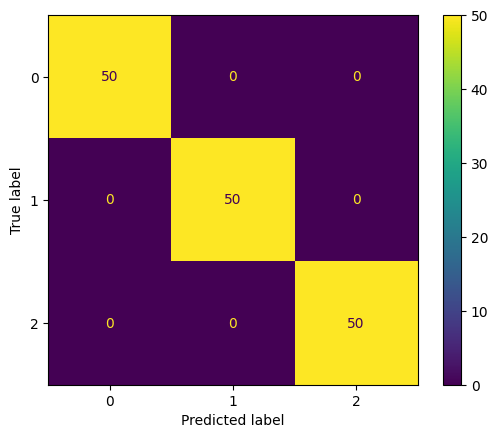

Recall:  1.0
Precision:  1.0
F1 score:  1.0 

----- TT 70-30 -----


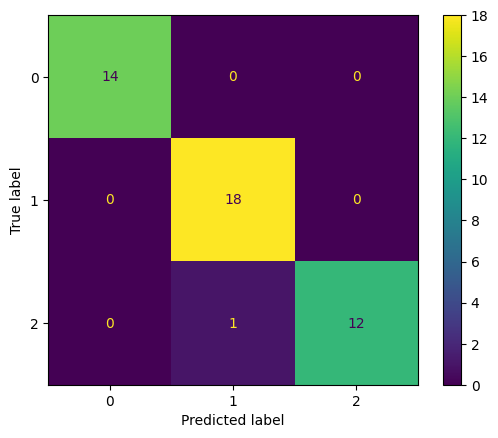

Recall:  0.9777777777777777
Precision:  0.9789473684210527
F1 score:  0.9776336336336338 

----- 10-FOLD CV -----
-- Fold  1
-- Fold  2
-- Fold  3
-- Fold  4
-- Fold  5
-- Fold  6
-- Fold  7
-- Fold  8
-- Fold  9
-- Fold  10
MEAN RECALL: 0.9600000000000002
MEAN PRECISION: 1.0
MEAN F1 SCORE: 0.9788177339901478


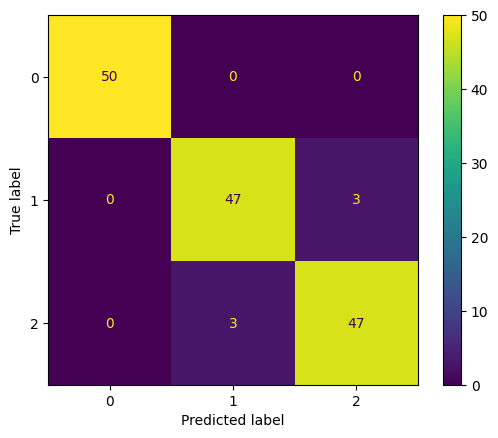

In [27]:
### TRAIN-ONLY
print("----- Train-only -----")

target_classes = iris_classes
input_train, target_train = iris_input, iris_target

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(input_train, target_train)
target_pred = knn.predict(input_train)

recall, precision, f1 = exact_methods(target_train, target_pred, 'weighted')
cm = plot_cm(target_train, target_pred, target_classes)

print("Recall: ", recall)
print("Precision: ", precision)
print("F1 score: ", f1, "\n")



### TT 70-30
print("----- TT 70-30 -----")

target_classes = iris_classes
input_train, input_test, target_train, target_test = tt(iris_input, iris_target, 30)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(input_train, target_train)
target_pred = knn.predict(input_test)

recall, precision, f1 = exact_methods(target_test, target_pred, 'weighted')
cm = plot_cm(target_test, target_pred, target_classes)

print("Recall: ", recall)
print("Precision: ", precision)
print("F1 score: ", f1, "\n")



### 10-FOLD CV
print("----- 10-FOLD CV -----")

target_classes = iris_classes
fold = 10
kf_input_train, kf_input_test, kf_target_train, kf_target_test = k_fold_arrays(iris_input, iris_target, fold)

mean_recall = 0.00
mean_precision = 0.00
mean_f1 = 0.00
total_target_test = []
total_target_pred = []
for i in range(len(kf_target_test)):
    input_train = kf_input_train[i]
    input_test = kf_input_test[i]
    target_train = kf_target_train[i]
    target_test = kf_target_test[i]

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(input_train, target_train)
    target_pred = knn.predict(input_test)
    total_target_test.extend(target_test)
    total_target_pred.extend(target_pred)

    recall, precision, f1 = exact_methods(target_test, target_pred, 'weighted')
    mean_recall += recall
    mean_precision += precision
    mean_f1 += f1


print("MEAN RECALL:", mean_recall/fold)
print("MEAN PRECISION:", mean_precision/fold)
print("MEAN F1 SCORE:", mean_f1/fold)
cm = plot_cm(total_target_test, total_target_pred, target_classes)






### 2.1.2. Train-only, TVT 40-30-30 e 10x10CV, fazendo variar k na gama {1, 3, 5, …, 15}.

In [28]:
## TESTE COM DATASET DECENTE

## 10-FOLD CV
print("----- TVT 40-30-30 -----")

target_classes = hacti_classes
input_train, input_val, input_test, target_train, target_val, target_test = tvt(hacti_input, hacti_target, 57.1428, 30) # 3 simples -> 70-100; 40-x; x = 40*100/70 = 57.1428 

print("-- 1st iteration (with val set)")
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(input_train, target_train)
target_val_pred = knn.predict(input_val)

recall, precision, f1 = exact_methods(target_val, target_val_pred, 'weighted')
cm = plot_cm(target_val, target_val_pred, target_classes)

print("Recall: ", recall)
print("Precision: ", precision)
print("F1 score: ", f1, "\n")


print("-- 2nd iteration (with test set)")
input_train, input_test, target_train, target_test = tt(hacti_input, hacti_target, 30)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(input_train, target_train)
target_pred = knn.predict(input_test)

scores = cross_val_score(knn, input_train, target_train, scoring='accuracy', cv=10, n_jobs=-1)
print(np.mean(scores))
recall, precision, f1 = exact_methods(target_test, target_pred, 'weighted')
cm = plot_cm(target_test, target_pred, target_classes)

print("Recall: ", recall)
print("Precision: ", precision)
print("F1 score: ", f1, "\n")




----- TVT 40-30-30 -----
-- 1st iteration (with val set)


KeyboardInterrupt: 

In [ ]:
### TT 70-30
print("----- TT 70-30 -----")

target_classes = iris_classes
input_train, input_test, target_train, target_test = tt(iris_input, iris_target, 30)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(input_train, target_train)
target_pred = knn.predict(input_test)

recall, precision, f1 = exact_methods(target_test, target_pred, 'weighted')
cm = plot_cm(target_test, target_pred, target_classes)

print("Recall: ", recall)
print("Precision: ", precision)
print("F1 score: ", f1, "\n")



### 10-FOLD CV
print("----- 10-FOLD CV -----")

target_classes = iris_classes
fold = 10
kf_input_train, kf_input_test, kf_target_train, kf_target_test = k_fold_arrays(iris_input, iris_target, fold)

mean_recall = 0.00
mean_precision = 0.00
mean_f1 = 0.00
total_target_test = []
total_target_pred = []
for i in range(len(kf_target_test)):
    input_train = kf_input_train[i]
    input_test = kf_input_test[i]
    target_train = kf_target_train[i]
    target_test = kf_target_test[i]

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(input_train, target_train)
    target_pred = knn.predict(input_test)
    total_target_test.extend(target_test)
    total_target_pred.extend(target_pred)

    recall, precision, f1 = exact_methods(target_test, target_pred, 'weighted')
    mean_recall += recall
    mean_precision += precision
    mean_f1 += f1


print("MEAN RECALL:", mean_recall/fold)
print("MEAN PRECISION:", mean_precision/fold)
print("MEAN F1 SCORE:", mean_f1/fold)
cm = plot_cm(total_target_test, total_target_pred, target_classes)

In [ ]:
## TVT 40-30-30
print("----- TVT 40-30-30 -----")

target_classes = iris_classes
input_train, input_val, input_test, target_train, target_val, target_test = tvt(iris_input, iris_target, 57.1428, 30) # 3 simples -> 70-100; 40-x; x = 40*100/70 = 57.1428 

print("-- 1st iteration (with val set)")
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(input_train, target_train)
target_val_pred = knn.predict(input_val)

recall, precision, f1 = exact_methods(target_val, target_val_pred, 'weighted')
cm = plot_cm(target_val, target_val_pred, target_classes)

print("Recall: ", recall)
print("Precision: ", precision)
print("F1 score: ", f1, "\n")

print("-- 2nd iteration (with test set)")
input_train, input_test, target_train, target_test = tt(iris_input, iris_target, 30)
print(input_train.size)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(input_train, target_train)
target_pred = knn.predict(input_test)

recall, precision, f1 = exact_methods(target_test, target_pred, 'weighted')
cm = plot_cm(target_test, target_pred, target_classes)

print("Recall: ", recall)
print("Precision: ", precision)
print("F1 score: ", f1, "\n")


## 10-FOLD CV
print("----- 10-FOLD CV -----")

target_classes = iris_classes
input_train, input_test, target_train, target_test = k_fold_arrays(iris_input, iris_target, 10)

for k_neigh in [1, 3, 5, 7, 9, 11, 13, 15]:
    print("-- k: ", k_neigh)
    knn = KNeighborsClassifier(n_neighbors=k_neigh)
    knn.fit(input_train, target_train)
    target_pred = knn.predict(input_test)

    knn.kneighbors = k_neigh

    recall, precision, f1 = exact_methods(target_test, target_pred, 'weighted')
    cm = plot_cm(target_test, target_pred, target_classes)

In [ ]:
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = tt(X, y, 0.5)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train) #train
y_pred = knn.predict(X_test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
acc = knn.score(X_test, y_test) #test

from sklearn.model_selection import cross_val_score

knn_cv = KNeighborsClassifier(n_neighbors=6)
#train model with cv of 5 
cv_scores = cross_val_score(knn_cv, X, y, cv=10)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

In [ ]:
neighbours = np.linspace(1, 15, 8)

for n in neighbours:
    knn = KNeighborsClassifier(n_neighbors=int(n))
    knn.fit(X, y)
    

In [ ]:
neigh = np.linspace(1, 15, 8)
print(neigh)

# TT, TVT e nCV

In [ ]:
#def tt(X, y, test_size):

def cross_validation(train_X, train_y, num_folds=10, k=1):
    dataset = list()
    dataset_split = list()
    val_acc = list()
    
    for i in range(len(train_X)):
        data = np.append(train_X[i],train_y[i])
        dataset.append(data)
    
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / num_folds)
    
    for i in range(num_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
        
    for folds in dataset_split:
        train_set= folds
        train_set = np.array(train_set)
        test_set = list()
        for row in folds:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        test_set = np.array(test_set)
        train_x = train_set[:, :-1]
        train_y = train_set[:,-1]
        test_x = test_set[:, :-1]
        predicted = predict(train_x,train_y, test_x, k)
        actual = [row[-1] for row in fold]
        accuracy = compute_accuracy(actual, predicted)
        val_acc.append(accuracy)
        
    val_acc_var = statistics.variance(val_acc)
    vall_acc = sum(val_acc)/len(val_acc)

    return vall_acc, val_acc_var

# Sobre overfitting

Overfitting refers to an unwanted behavior of a machine learning algorithm used for predictive modeling.

It is the case where model performance on the training dataset is improved at the cost of worse performance on data not seen during training, such as a holdout test dataset or new data.

We can identify if a machine learning model has overfit by first evaluating the model on the training dataset and then evaluating the same model on a holdout test dataset.

If the performance of the model on the training dataset is significantly better than the performance on the test dataset, then the model may have overfit the training dataset.


## Usar as features dadas pelo Relief

In [ ]:
neighbours = 5
x_relief = relief(X, y, neighbours, 10) # TODO qual o numero de features que se quer
# TODO tem que se alterar o algoritmo de relief?
print(x_relief.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(x_relief, y, test_size=0.3, random_state=1)

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train) #train
y_pred = knn.predict(X_test)

f1_score(y_pred, y_test, average=None)

In [ ]:
error_rate = []# Will take some time
for i in range(1, X_train.shape[1]+1):
    print(i)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,X_train.shape[1]+1),error_rate,color='blue', linestyle='dashed', marker='o',
 markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

# 3. Análise ao *dataset* original

In [ ]:
loc = []

for i in range (0,15):
    loc.append("FORTH_TRACE_DATASET-master/part" + str(i) + "/part" + str(i) + "dev2.csv")

array = []
for file in loc:
    df = pd.read_csv(file, sep=',', header=None)
    array.append(df.to_numpy())

array = np.concatenate(array)
print(array.shape)

___

# 4. Repita o ponto 2 no dataset de actividades humanos utilizado neste trabalho, usando data splitting **TVT** (apenas TVT; CV não é para fazer), uma **rede neuronal feedforward** (MLP) com **3 camadas**, **número variável de neurónios na camada escondida**, função de **activação logística** em todos os neurónios, **batch learning** e as features seleccionadas nas alíneas anteriores:

### 4.1. Com velocidade de aprendizagem fixo

In [ ]:
input_data, target_data = iris_input, iris_target

input_train, input_val, input_test, target_train, target_val, target_test = tvt(input_data, target_data, 30, 30)

feedforward = MLPClassifier(learning_rate='adaptive', activation='logistic', batch_size='lbfgs', solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, ), random_state=1)

feedforward.fit(input_train, target_train)

print(target_test)
target_pred = feedforward.predict(input_test)
print(target_pred)

recall, precision, f1 = exact_methods(target_test, target_pred, None)

